In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
from pyspark.sql import functions as F, Window
from manga_recsys.spark import get_spark

spark = get_spark()

In [19]:
from IPython.display import display
from manga_recsys.models.manga import generate_manga_tags_word2vec

manga_info = spark.read.parquet(
    "../data/processed/2022-12-17-metadata-listing/manga_info.parquet"
)

manga_tags, model = generate_manga_tags_word2vec(
    manga_info, vector_col="w2v", return_model=True
)
manga_tags.head()

,id,tags,w2v
0,0001183c-2089-48e9-96b7-d48db5f1a611,"[Psychological, Drama, Supernatural]","[1.209808588027954, -0.6644144058227539, 0.742..."
1,00016bf9-455f-44e5-ab27-55ac7f69aad2,"[Oneshot, Sci-Fi, Post-Apocalyptic, Tragedy]","[1.930620551109314, 0.12979134917259216, 1.429..."
2,000245bf-670e-49c5-af47-1d674a43525c,"[Comedy, Video Games, Slice of Life, Music]","[0.7073773741722107, -0.20437663793563843, 0.3..."
3,00034238-6f5d-4f98-a51c-69afb21d920f,"[Oneshot, Boys' Love, Doujinshi]","[-0.39188352227211, 0.4122333228588104, 0.7059..."
4,0003d7e8-31da-463b-97e9-e87045f8f5ee,"[Oneshot, Romance, Doujinshi, Drama, Slice of ...","[0.2792929708957672, -0.1556491106748581, 0.66..."


f:\code\mangadex\.venv\lib\site-packages\pyspark\sql\pandas\conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


+-------------+-----+
|          tag|count|
+-------------+-----+
|      Fantasy|  815|
|       Action|  578|
|   Full Color|  191|
|    Adventure|  158|
|       Comedy|  135|
|   Adaptation|  119|
|      Romance|   24|
|Reincarnation|   19|
|        Drama|   19|
|   Long Strip|   15|
+-------------+-----+
only showing top 10 rows

+--------------------+--------------------+---------+
|                  id|                 w2v|      tag|
+--------------------+--------------------+---------+
|000b6cbb-f99a-458...|[0.62514901161193...|  Fantasy|
|0014776a-d47f-461...|[0.79004502296447...|Adventure|
|002871dd-5d07-420...|[0.93722379207611...|   Action|
|0030db10-93a6-4f6...|[0.30603492259979...|  Fantasy|
|005143c6-d844-4e5...|[0.44614881277084...|   Comedy|
+--------------------+--------------------+---------+
only showing top 5 rows

2112


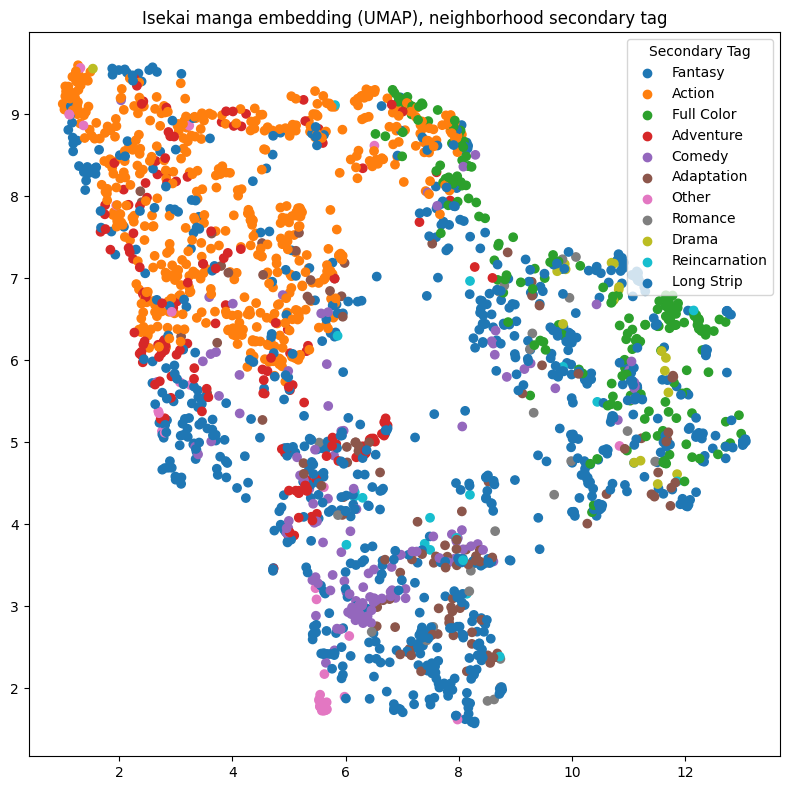

In [82]:
from pynndescent import NNDescent
from manga_recsys.models.manga import generate_recommendations, explode_recommendations
import umap
import numpy as np
import matplotlib.pyplot as plt

# keep only manga that contains the following tag
def recs_with_secondary_tag(primary_tag, df, k_recs=20, k_tags=5, verbose=True):
    manga_with_tag = manga_tags[
        manga_tags.tags.apply(",".join).str.contains(primary_tag)
    ].reset_index()
    recs = generate_recommendations(manga_with_tag, "id", "w2v", k=k_recs)

    # get the most common tag from each neighbor
    # this is a type of belief propagation algorithm
    tag_mode = (
        explode_recommendations(spark, recs)
        .join(
            spark.createDataFrame(manga_tags)
            .select("id", "tags")
            .withColumnRenamed("id", "rec_id"),
            on="rec_id",
        )
        .withColumn("tag", F.explode("tags"))
        .groupBy("id", "tag")
        .count()
        .where(F.col("tag") != primary_tag)
        # now keep the most common tag for each manga
        .withColumn(
            "rank",
            F.rank().over(
                Window.partitionBy("id").orderBy(F.col("count").desc(), F.col("tag"))
            ),
        )
        .where(F.col("rank") == 1)
        .drop("rank")
    )

    if verbose:
        # tag_mode.show(n=5)
        tag_mode.groupBy("tag").count().orderBy(F.col("count").desc()).show(n=10)

    # keep the top 5 tags, otherwise label it as "other"
    top_tags = (
        tag_mode.groupBy("tag")
        .count()
        .orderBy(F.col("count").desc())
        .limit(k_tags)
        .drop("count")
        .withColumn("common", F.lit(True))
    )

    tag_common = (
        tag_mode.join(top_tags, on="tag", how="left")
        .fillna(False, subset=["common"])
        .withColumn("tag", F.when(F.col("common"), F.col("tag")).otherwise("Other"))
        .drop("common")
    )

    df = (spark.createDataFrame(recs).join(tag_common, on="id", how="left")).select(
        "id", "w2v", "tag"
    )
    if verbose:
        df.show(n=5)
    print(df.count())
    return df.toPandas()


def plot(df, reducer, title, sample=None):
    if sample is not None:
        df = df.sample(sample)
    manga_vectors_2d = reducer.fit_transform(np.stack(df.w2v))

    # add color map for the tag using convention
    tag_freq = df.groupby("tag").count().sort_values("id", ascending=False)
    color_map = {tag: f"C{i}" for i, tag in enumerate(tag_freq.index)}
    # print(tag_freq)
    # print(color_map)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(
        manga_vectors_2d[:, 0],
        manga_vectors_2d[:, 1],
        c=df.tag.fillna("Other").apply(color_map.get),
    )

    # add legend
    for tag, color in color_map.items():
        ax.scatter([], [], c=color, label=tag)

    ax.set_title(title)
    ax.legend(loc="upper right", title="Secondary Tag")

    plt.tight_layout()
    plt.show()


primary_tag = "Isekai"
plot(
    recs_with_secondary_tag(primary_tag, manga_tags, k_recs=20, k_tags=10),
    umap.UMAP(n_components=2, random_state=0, metric="cosine"),
    title=f"{primary_tag} manga embedding (UMAP), neighborhood secondary tag",
)

f:\code\mangadex\.venv\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
f:\code\mangadex\.venv\lib\site-packages\pyspark\sql\pandas\conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


+----------+-----+
|       tag|count|
+----------+-----+
|    Action| 4537|
|    Comedy| 1581|
|Full Color| 1266|
| Adventure|  845|
|   Romance|  639|
|     Drama|  586|
| Doujinshi|  424|
|Long Strip|  346|
|Boys' Love|  316|
|Adaptation|  310|
+----------+-----+
only showing top 10 rows

+--------------------+--------------------+----------+
|                  id|                 w2v|       tag|
+--------------------+--------------------+----------+
|085cd1c3-8a7b-4bf...|[1.04802501201629...| Adventure|
|1064e8a5-0de9-401...|[0.06394797563552...|     Drama|
|189c552e-d2b8-488...|[0.16930164396762...|   Romance|
|2efeefd8-5c3f-480...|[0.08044908195734...|Adaptation|
|47c33ec4-5373-4de...|[-0.0861416906118...|    Action|
+--------------------+--------------------+----------+
only showing top 5 rows

12470


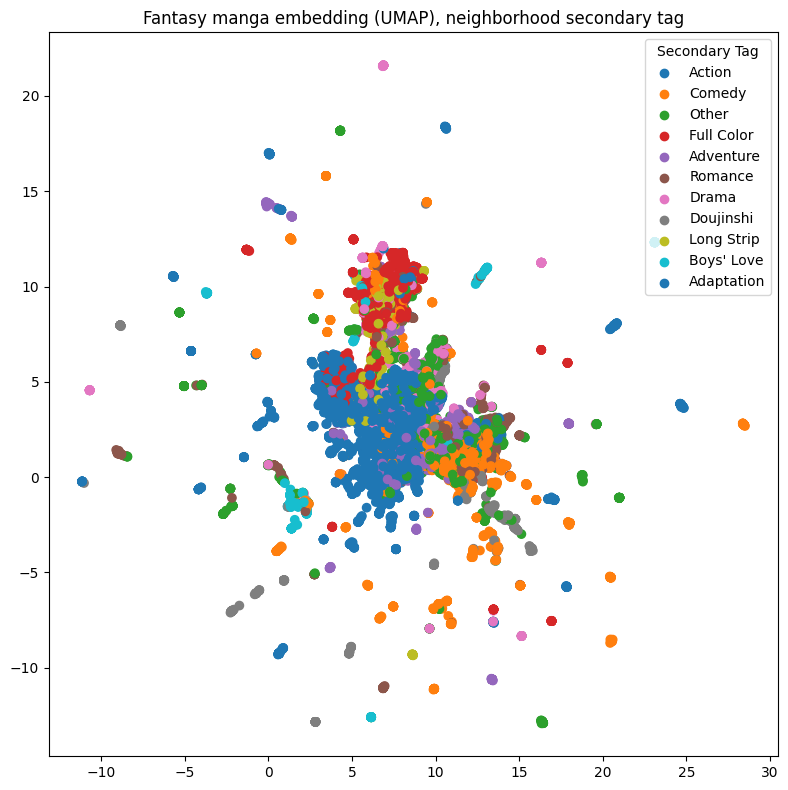

In [83]:
primary_tag = "Fantasy"
plot(
    recs_with_secondary_tag(primary_tag, manga_tags, k_tags=10),
    umap.UMAP(n_components=2, random_state=0, metric="cosine"),
    title=f"{primary_tag} manga embedding (UMAP), neighborhood secondary tag",
)

f:\code\mangadex\.venv\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
f:\code\mangadex\.venv\lib\site-packages\pyspark\sql\pandas\conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


+----------+-----+
|       tag|count|
+----------+-----+
|    Action| 4537|
|    Comedy| 1579|
|Full Color| 1269|
| Adventure|  846|
|   Romance|  636|
|     Drama|  588|
| Doujinshi|  423|
|Long Strip|  344|
|Boys' Love|  314|
|Adaptation|  309|
+----------+-----+
only showing top 10 rows

+--------------------+--------------------+---------+
|                  id|                 w2v|      tag|
+--------------------+--------------------+---------+
|085cd1c3-8a7b-4bf...|[1.04802501201629...|Adventure|
|1064e8a5-0de9-401...|[0.06394797563552...|    Drama|
|189c552e-d2b8-488...|[0.16930164396762...|  Romance|
|2efeefd8-5c3f-480...|[0.08044908195734...|    Other|
|47c33ec4-5373-4de...|[-0.0861416906118...|   Action|
+--------------------+--------------------+---------+
only showing top 5 rows

12470


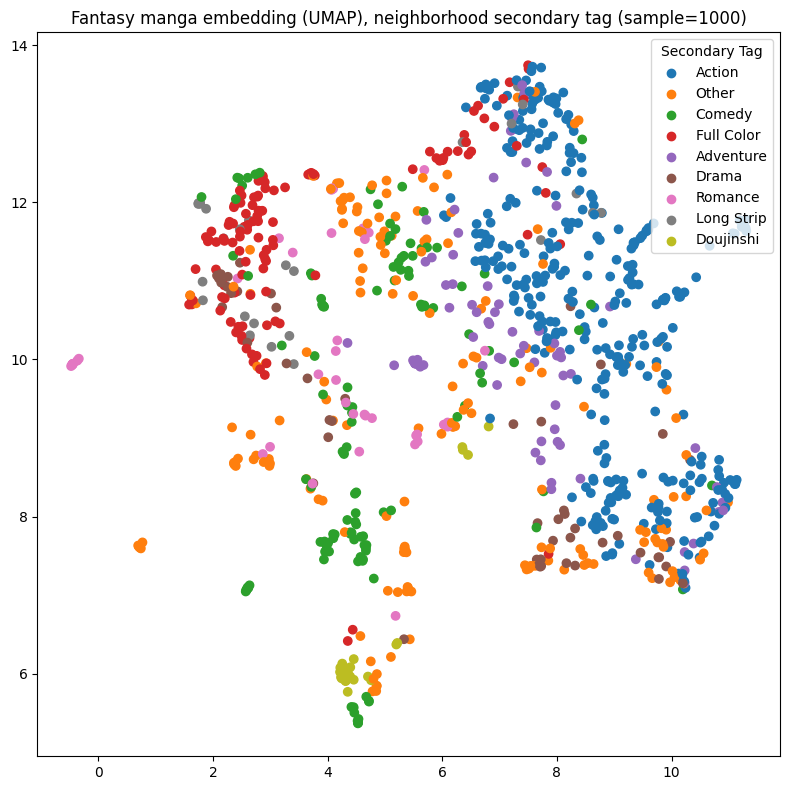

In [89]:
primary_tag = "Fantasy"
sample = 1000
plot(
    recs_with_secondary_tag(primary_tag, manga_tags, k_tags=8),
    umap.UMAP(n_components=2, random_state=0, metric="cosine"),
    title=f"{primary_tag} manga embedding (UMAP), neighborhood secondary tag (sample={sample})",
    sample=sample,
)

f:\code\mangadex\.venv\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
f:\code\mangadex\.venv\lib\site-packages\pyspark\sql\pandas\conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


+-------------+-----+
|          tag|count|
+-------------+-----+
|       Comedy| 6861|
|   Boys' Love| 3742|
|        Drama| 3627|
|      Fantasy| 2114|
|       Action| 2066|
|   Full Color| 1405|
|      Oneshot|  938|
|  School Life|  752|
|    Doujinshi|  686|
|Slice of Life|  418|
+-------------+-----+
only showing top 10 rows

+--------------------+--------------------+----------+
|                  id|                 w2v|       tag|
+--------------------+--------------------+----------+
|07c7ac62-c738-480...|[0.21225312352180...|   Fantasy|
|07d69599-62a9-446...|[0.19386616349220...|Full Color|
|07d858d0-1537-487...|[1.66138851642608...|    Action|
|4036eb2d-0125-4f3...|[-0.1535870432853...|Boys' Love|
|80042b07-84dc-4e9...|[-0.3086937665939...|     Drama|
+--------------------+--------------------+----------+
only showing top 5 rows

25827


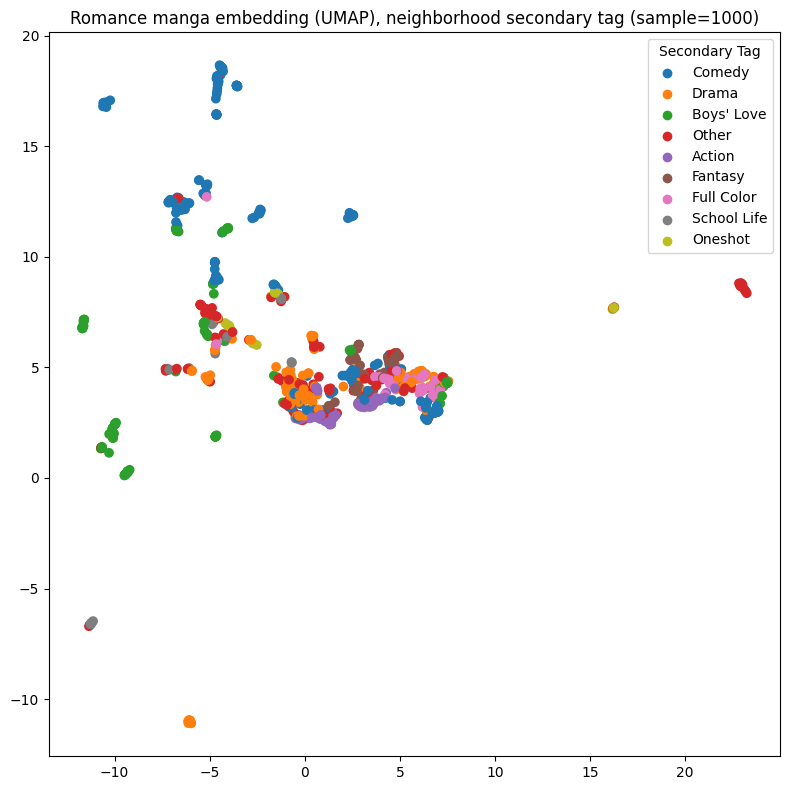

In [90]:
primary_tag = "Romance"
sample = 1000
plot(
    recs_with_secondary_tag(primary_tag, manga_tags, k_tags=8),
    umap.UMAP(n_components=2, random_state=0, metric="cosine"),
    title=f"{primary_tag} manga embedding (UMAP), neighborhood secondary tag (sample={sample})",
    sample=sample,
)

f:\code\mangadex\.venv\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
f:\code\mangadex\.venv\lib\site-packages\pyspark\sql\pandas\conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


+----------+-----+
|       tag|count|
+----------+-----+
|    Comedy| 4976|
|     Drama| 1933|
|Boys' Love| 1502|
|   Romance|  779|
|    Action|  640|
|   Fantasy|  581|
|   Oneshot|  503|
|Full Color|  501|
| Doujinshi|  479|
|    4-Koma|  259|
+----------+-----+
only showing top 10 rows

+--------------------+--------------------+-------+
|                  id|                 w2v|    tag|
+--------------------+--------------------+-------+
|17b214b6-abbc-41e...|[1.57449162006378...|  Other|
|17b3b648-fd89-4a6...|[0.64272183179855...|Fantasy|
|28220fbf-03eb-46a...|[0.37687137722969...| Action|
|38f59554-6504-45f...|[0.36075353622436...| Comedy|
|403271f8-61d9-4fc...|[0.78850245475769...| Comedy|
+--------------------+--------------------+-------+
only showing top 5 rows

13781


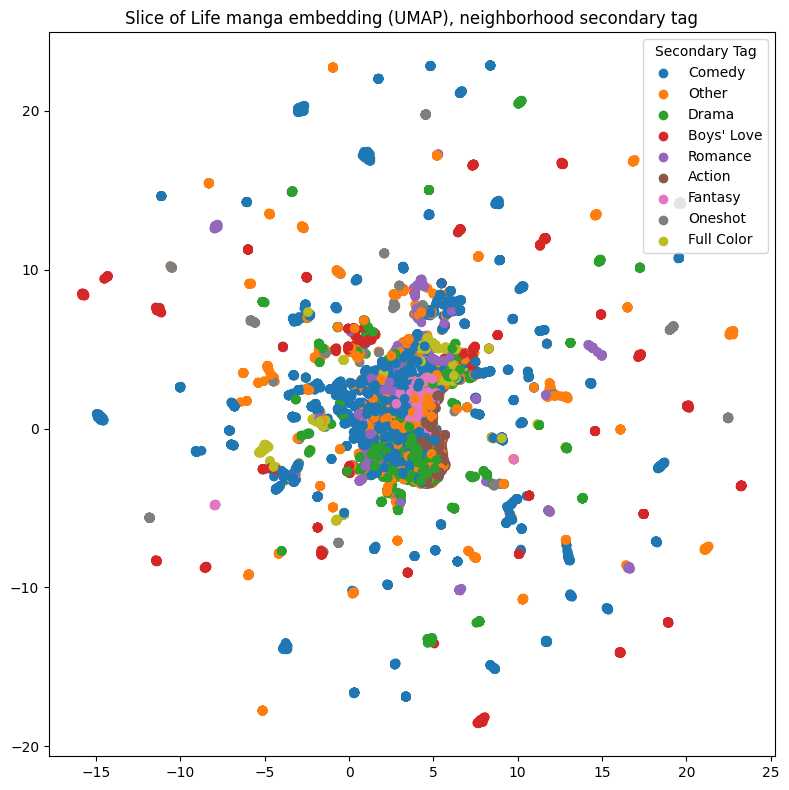

In [91]:
primary_tag = "Slice of Life"
plot(
    recs_with_secondary_tag(primary_tag, manga_tags, k_tags=8),
    umap.UMAP(n_components=2, random_state=0, metric="cosine"),
    title=f"{primary_tag} manga embedding (UMAP), neighborhood secondary tag",
)

f:\code\mangadex\.venv\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
f:\code\mangadex\.venv\lib\site-packages\pyspark\sql\pandas\conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


+----------+-----+
|       tag|count|
+----------+-----+
|    Comedy| 4976|
|     Drama| 1929|
|Boys' Love| 1499|
|   Romance|  783|
|    Action|  640|
|   Fantasy|  582|
|   Oneshot|  508|
|Full Color|  505|
| Doujinshi|  475|
|    4-Koma|  257|
+----------+-----+
only showing top 10 rows

+--------------------+--------------------+-------+
|                  id|                 w2v|    tag|
+--------------------+--------------------+-------+
|17b214b6-abbc-41e...|[1.57449162006378...|  Other|
|17b3b648-fd89-4a6...|[0.64272183179855...|Fantasy|
|28220fbf-03eb-46a...|[0.37687137722969...| Action|
|38f59554-6504-45f...|[0.36075353622436...| Comedy|
|403271f8-61d9-4fc...|[0.78850245475769...| Comedy|
+--------------------+--------------------+-------+
only showing top 5 rows

13781


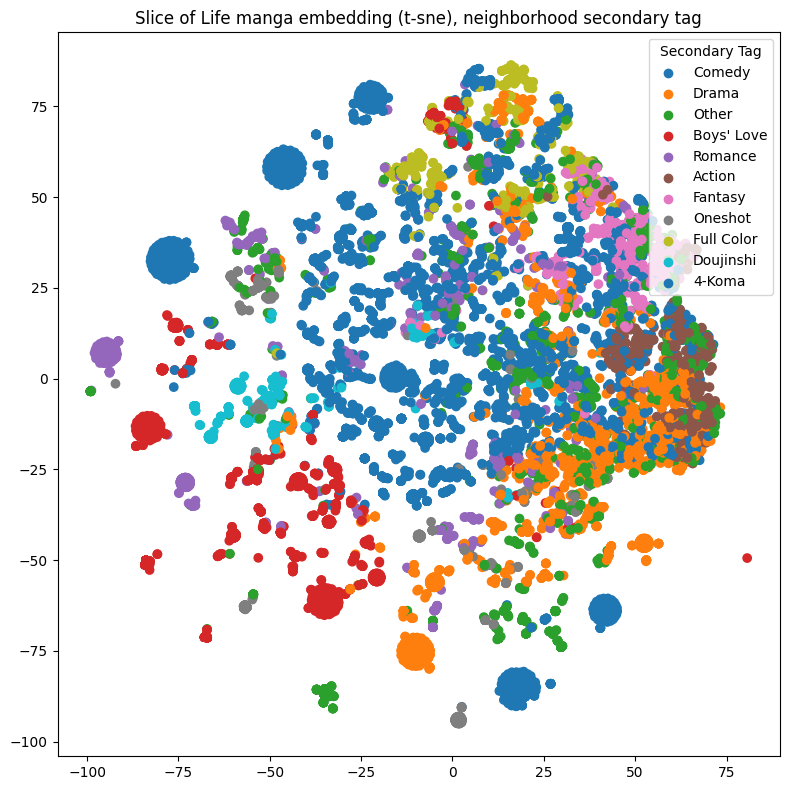

In [95]:
# use TSNE instead of UMAP

from sklearn.manifold import TSNE

primary_tag = "Slice of Life"
plot(
    recs_with_secondary_tag(primary_tag, manga_tags, k_tags=10),
    TSNE(n_components=2, random_state=0, metric="cosine"),
    title=f"{primary_tag} manga embedding (t-sne), neighborhood secondary tag",
)

f:\code\mangadex\.venv\lib\site-packages\pyspark\sql\pandas\conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


+-------------+-----+
|          tag|count|
+-------------+-----+
|      Fantasy|  816|
|       Action|  578|
|   Full Color|  191|
|    Adventure|  156|
|       Comedy|  136|
|   Adaptation|  120|
|      Romance|   23|
|Reincarnation|   19|
|        Drama|   19|
|   Long Strip|   15|
+-------------+-----+
only showing top 10 rows

+--------------------+--------------------+---------+
|                  id|                 w2v|      tag|
+--------------------+--------------------+---------+
|000b6cbb-f99a-458...|[0.62514901161193...|  Fantasy|
|0014776a-d47f-461...|[0.79004502296447...|Adventure|
|002871dd-5d07-420...|[0.93722379207611...|   Action|
|0030db10-93a6-4f6...|[0.30603492259979...|  Fantasy|
|005143c6-d844-4e5...|[0.44614881277084...|   Comedy|
+--------------------+--------------------+---------+
only showing top 5 rows

2112


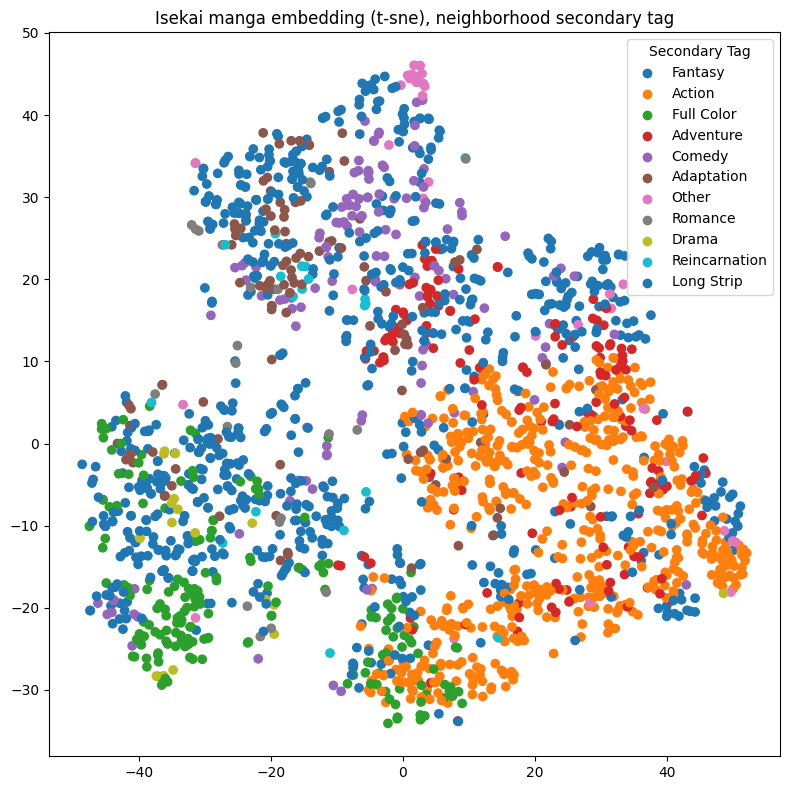

In [94]:
primary_tag = "Isekai"
plot(
    recs_with_secondary_tag(primary_tag, manga_tags, k_tags=10),
    TSNE(n_components=2, random_state=0, metric="cosine"),
    title=f"{primary_tag} manga embedding (t-sne), neighborhood secondary tag",
)